# EDMD-DL Tests on Duffing Oscillator

Import necessary modules

In [1]:
import sys
sys.path.append('..')
import KoopmanDL as kdl
import torch
import matplotlib.pyplot as plt

Generate the data set

In [2]:
n_init = 1300
traj_len = 10
traj_t_step = 0.25
n_train = 10000
n_valid = 3000
dt = 1e-3
seed = 0
x_min = -2
x_max = 2

duffing = kdl.DuffingOscillator(alpha=1.0, beta=-1.0, delta=0.5)
flowmap = kdl.ForwardEuler(dt)
data_x_all = flowmap.generate_traj_data(duffing, n_init, traj_len, traj_t_step, x_min, x_max, seed)
data_y_all = flowmap.step(duffing, data_x_all)
dataset = kdl.DataSet(data_x_all, data_y_all)
data_train, data_valid = dataset.split(n_train)

Visualize data

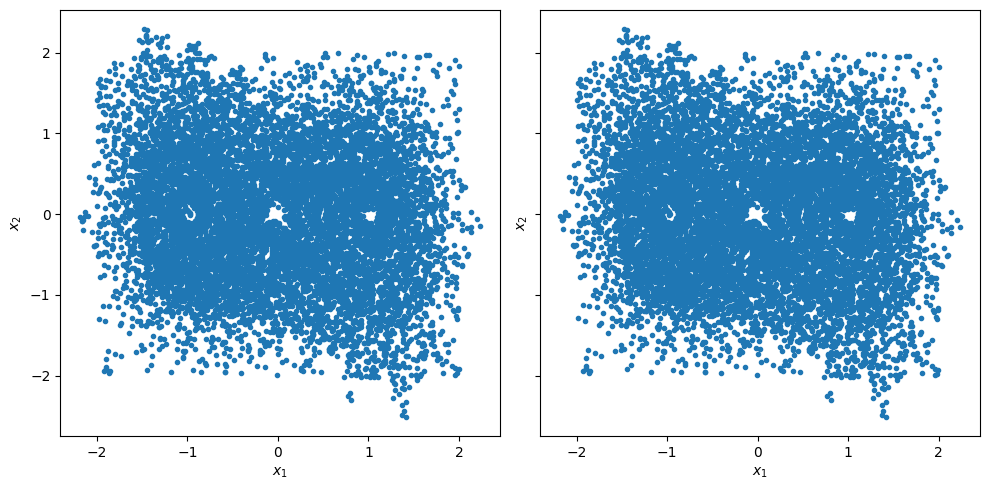

In [3]:
fig, (ax1,ax2) = plt.subplots(1,2,sharey=True, figsize=(10,5))
data_x_train = data_train.data()
ax1.plot(data_x_train[:,0], data_x_train[:,1], '.')
ax1.set_xlabel(r'$x_{1}$')
ax1.set_ylabel(r'$x_{2}$')
data_y_train = data_train.labels()
ax2.plot(data_y_train[:,0], data_y_train[:,1], '.')
ax2.set_xlabel(r'$x_{1}$')
ax2.set_ylabel(r'$x_{2}$')
plt.tight_layout()